# **Section 1: Rolling Average and Anomaly Flagging**

Compute a 24-period rolling average of ridership for each station and flag significantly low values as anomalies.

In [ ]:
# Install Java and Spark 3.3.2 (Hadoop 3) from Apache archive
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.3.2/spark-3.3.2-bin-hadoop3.tgz
!tar xf spark-3.3.2-bin-hadoop3.tgz
!pip install -q findspark


In [ ]:
import os
import findspark

os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.3.2-bin-hadoop3"
findspark.init()

from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").appName("ColabSpark").getOrCreate()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

df = spark.read.parquet("/content/drive/MyDrive/BD_Project/mta_hourly_features.parquet")
df.show(5)


Mounted at /content/drive
+--------------------+------------+------------------+--------------------+---------+--------------+--------------------+---------+---------+---------+----------+--------------------+-------------------+----+-----+---+----+-------+----------+----------------+-----------+------------------+-----------------------+-------------------+
|   transit_timestamp|transit_mode|station_complex_id|     station_complex|  borough|payment_method| fare_class_category|ridership|transfers| latitude| longitude|        Georeference|                 ts|year|month|day|hour|weekday|is_weekend|transit_mode_idx|borough_idx|payment_method_idx|fare_class_category_idx|station_complex_idx|
+--------------------+------------+------------------+--------------------+---------+--------------+--------------------+---------+---------+---------+----------+--------------------+-------------------+----+-----+---+----+-------+----------+----------------+-----------+------------------+--------------

## 1.1: Daily + Rolling Average Ridership Plot

<ipython-input-26-8f5be76da9e4>:33: UserWarning: Glyph 128197 (\N{CALENDAR}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128197 (\N{CALENDAR}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


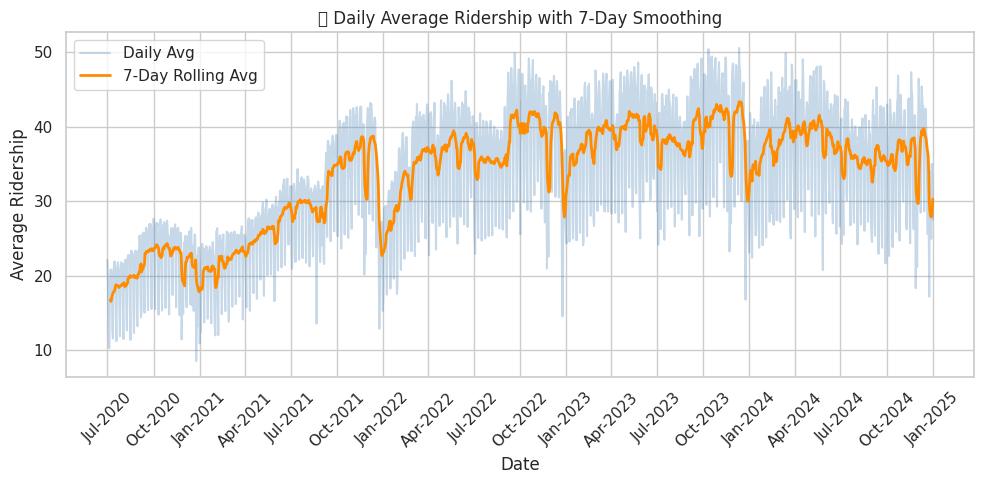

In [26]:
from pyspark.sql.functions import to_date, avg
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

# Group by date and calculate average ridership
df_daily = (
    df.withColumn("date", to_date("ts"))
      .groupBy("date")
      .agg(avg("ridership").alias("daily_avg"))
      .orderBy("date")
)

# Convert to Pandas for plotting
pdf_daily = df_daily.toPandas()
pdf_daily.set_index("date", inplace=True)
pdf_daily["roll7"] = pdf_daily["daily_avg"].rolling(window=7).mean()

# Plotting
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 5))
plt.plot(pdf_daily.index, pdf_daily["daily_avg"], alpha=0.3, label="Daily Avg", color="steelblue")
plt.plot(pdf_daily.index, pdf_daily["roll7"], label="7-Day Rolling Avg", color="darkorange", linewidth=2)

plt.title("📅 Daily Average Ridership with 7-Day Smoothing")
plt.xlabel("Date")
plt.ylabel("Average Ridership")
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%b-%Y"))
plt.legend()
plt.tight_layout()
plt.show()


## 1.2: Monthly Average Ridership

<ipython-input-27-b86736356103>:26: UserWarning: Glyph 128198 (\N{TEAR-OFF CALENDAR}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128198 (\N{TEAR-OFF CALENDAR}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


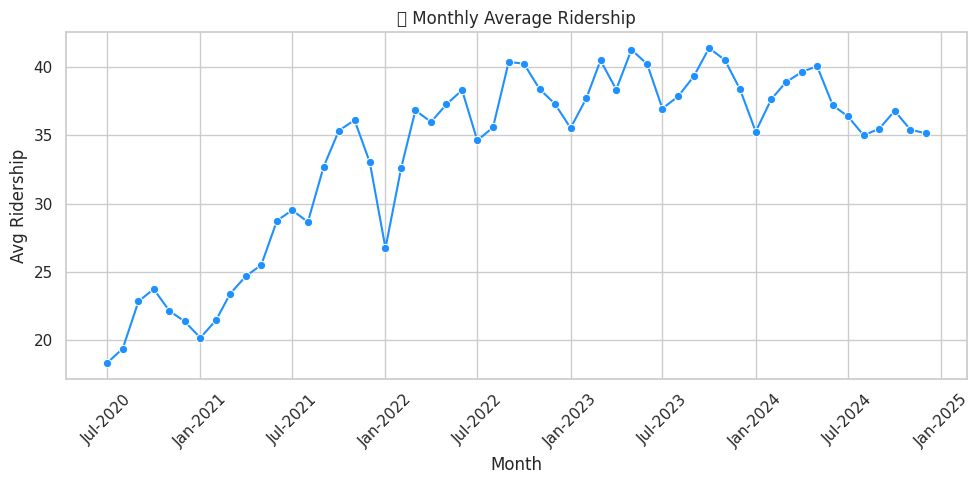

In [27]:
from pyspark.sql.functions import concat_ws, avg

# Group by year & month
df_monthly = (
    df.groupBy("year", "month")
      .agg(avg("ridership").alias("monthly_avg"))
      .orderBy("year", "month")
)

# Create YYYY-MM column for plotting
df_monthly = df_monthly.withColumn("month_str", concat_ws("-", df_monthly.year.cast("string"), df_monthly.month.cast("string")))

# Convert to Pandas
pdf_monthly = df_monthly.toPandas()
pdf_monthly["month_str"] = pd.to_datetime(pdf_monthly["month_str"])
pdf_monthly.set_index("month_str", inplace=True)

# Plot
plt.figure(figsize=(10, 5))
sns.lineplot(data=pdf_monthly, x=pdf_monthly.index, y="monthly_avg", marker="o", color="dodgerblue")
plt.title("📆 Monthly Average Ridership")
plt.xlabel("Month")
plt.ylabel("Avg Ridership")
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%b-%Y"))
plt.tight_layout()
plt.show()


## 1.3: Hour-of-Day Ridership Profile (Weekday vs Weekend)

<ipython-input-28-e48ca4d547fc>:21: UserWarning: Glyph 128338 (\N{CLOCK FACE THREE OCLOCK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128338 (\N{CLOCK FACE THREE OCLOCK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


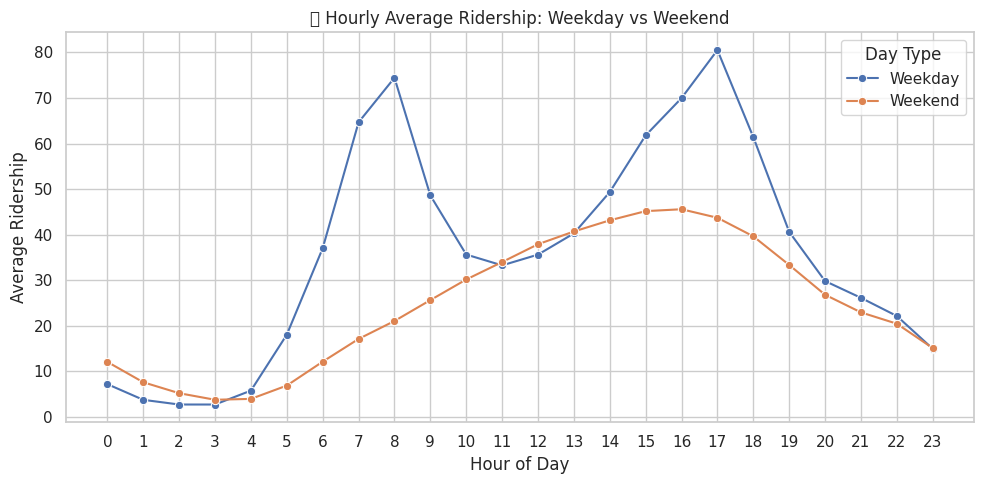

In [28]:
from pyspark.sql.functions import avg

# Group by hour and is_weekend
df_hourly = (
    df.groupBy("hour", "is_weekend")
      .agg(avg("ridership").alias("avg_ridership"))
      .orderBy("hour", "is_weekend")
)

# Convert to pandas for plotting
pdf_hourly = df_hourly.toPandas()
pdf_hourly["Day Type"] = pdf_hourly["is_weekend"].map({0: "Weekday", 1: "Weekend"})

# Plot
plt.figure(figsize=(10, 5))
sns.lineplot(data=pdf_hourly, x="hour", y="avg_ridership", hue="Day Type", marker="o")
plt.title("🕒 Hourly Average Ridership: Weekday vs Weekend")
plt.xlabel("Hour of Day")
plt.ylabel("Average Ridership")
plt.xticks(range(0, 24))
plt.tight_layout()
plt.show()


## 1.4: Top 20 Busiest Stations by Total Ridership

<ipython-input-30-922b3f4658ab>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="total_ridership", y="station_complex", data=pdf_station, palette="crest")
<ipython-input-30-922b3f4658ab>:20: UserWarning: Glyph 128205 (\N{ROUND PUSHPIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128205 (\N{ROUND PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


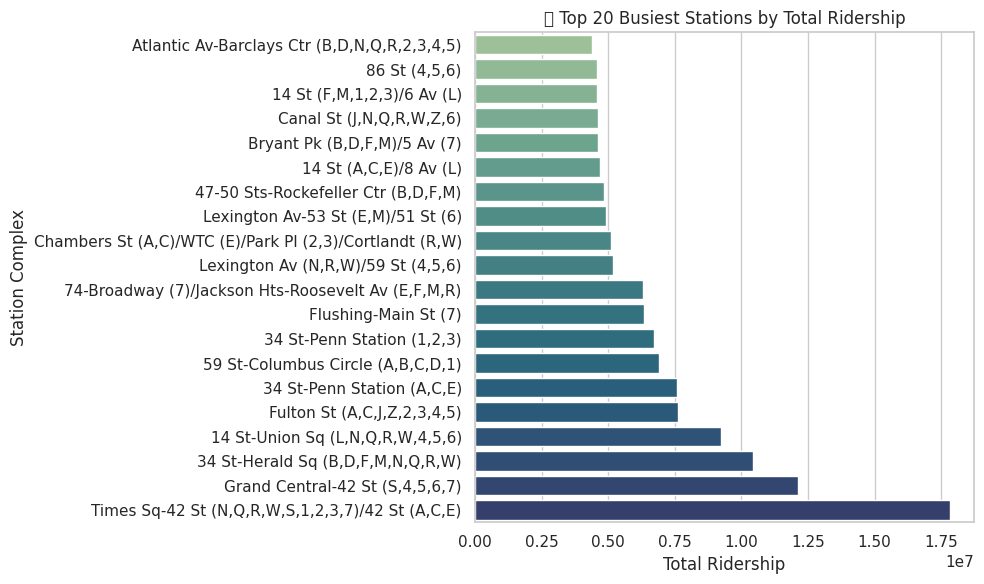

In [30]:
from pyspark.sql.functions import sum as _sum

# Aggregate total ridership by station
df_station = (
    df.groupBy("station_complex")
      .agg(_sum("ridership").alias("total_ridership"))
      .orderBy(F.desc("total_ridership"))
      .limit(20)
)

# Convert to Pandas
pdf_station = df_station.toPandas().sort_values("total_ridership", ascending=True)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x="total_ridership", y="station_complex", data=pdf_station, palette="crest")
plt.title("📍 Top 20 Busiest Stations by Total Ridership")
plt.xlabel("Total Ridership")
plt.ylabel("Station Complex")
plt.tight_layout()
plt.show()


## 1.5: Hour vs Weekday Heatmap

<ipython-input-31-b47d73ac7476>:24: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


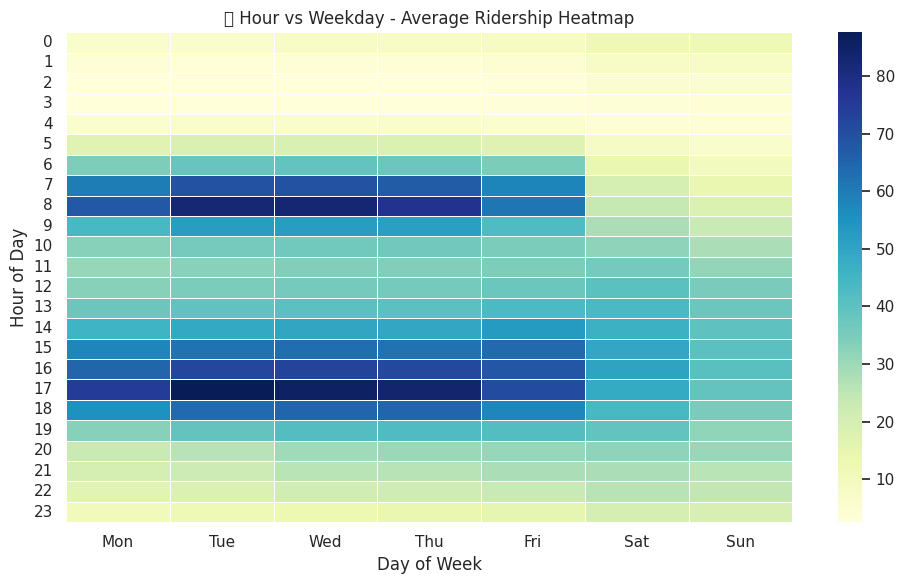

In [31]:
from pyspark.sql.functions import avg, date_format

# Add weekday column if not already present
df_weekhour = (
    df.withColumn("weekday_name", date_format("ts", "E"))
      .groupBy("hour", "weekday_name")
      .agg(avg("ridership").alias("avg_ridership"))
)

# Convert to pandas pivot table
pdf_weekhour = df_weekhour.toPandas()
heatmap_data = pdf_weekhour.pivot(index="hour", columns="weekday_name", values="avg_ridership")

# Optional: reorder columns
weekday_order = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
heatmap_data = heatmap_data[weekday_order]

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, cmap="YlGnBu", annot=False, linewidths=0.5)
plt.title("🔥 Hour vs Weekday - Average Ridership Heatmap")
plt.xlabel("Day of Week")
plt.ylabel("Hour of Day")
plt.tight_layout()
plt.show()


# **Section 2: Selecting a Sample Station for Analysis**

Choose a representative station from the dataset to visualize and explore delay-like patterns

## 2.1: Feature Vector Creation

In [32]:
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import log1p

# Create log of ridership for stable modeling
df_ml = df.withColumn("log_ridership", log1p("ridership"))

# Choose safe features (avoid high-cardinality like station_complex_idx)
feature_cols = [
    "hour", "day", "month", "year", "is_weekend",
    "transit_mode_idx", "borough_idx", "fare_class_category_idx", "payment_method_idx"
]

assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
df_prepared = assembler.transform(df_ml).select("features", "ridership", "log_ridership")

# Train-test split
train_df, test_df = df_prepared.randomSplit([0.8, 0.2], seed=42)


## 2.2: Train 3 Models (Linear, Random Forest, GBT)

### Model Training + Prediction + RMSE Evaluation

In [33]:
from pyspark.ml.regression import LinearRegression, RandomForestRegressor, GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import expm1

# Initialize models
lr = LinearRegression(featuresCol="features", labelCol="log_ridership", predictionCol="lr_pred")
rf = RandomForestRegressor(featuresCol="features", labelCol="log_ridership", predictionCol="rf_pred", maxBins=600, numTrees=50)
gbt = GBTRegressor(featuresCol="features", labelCol="log_ridership", predictionCol="gbt_pred", maxIter=50)

# Train
lr_model = lr.fit(train_df)
rf_model = rf.fit(train_df)
gbt_model = gbt.fit(train_df)

# Predict
test_pred = lr_model.transform(test_df)
test_pred = rf_model.transform(test_pred)
test_pred = gbt_model.transform(test_pred)

# Convert log predictions to actual scale
test_pred = (
    test_pred
    .withColumn("lr_pred_real", expm1("lr_pred"))
    .withColumn("rf_pred_real", expm1("rf_pred"))
    .withColumn("gbt_pred_real", expm1("gbt_pred"))
)

# Evaluate
evaluator = RegressionEvaluator(labelCol="ridership", predictionCol="lr_pred_real", metricName="rmse")
rmse_lr = evaluator.evaluate(test_pred)
evaluator.setPredictionCol("rf_pred_real")
rmse_rf = evaluator.evaluate(test_pred)
evaluator.setPredictionCol("gbt_pred_real")
rmse_gbt = evaluator.evaluate(test_pred)

print(f"📊 RMSE Comparison:")
print(f"  Linear Regression RMSE:       {rmse_lr:.2f}")
print(f"  Random Forest RMSE:           {rmse_rf:.2f}")
print(f"  Gradient Boosted Trees RMSE:  {rmse_gbt:.2f}")


📊 RMSE Comparison:
  Linear Regression RMSE:       117.45
  Random Forest RMSE:           114.48
  Gradient Boosted Trees RMSE:  104.12


## 2.3: SAVING MODELS

In [34]:
import os
from datetime import datetime

# ===  Set export folder
export_base = "/content/drive/MyDrive/BD_Project/exports"
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
model_dir = os.path.join(export_base, f"model_step2_2_{timestamp}")
os.makedirs(model_dir, exist_ok=True)

# ===  1. Save Models
lr_model.write().overwrite().save(os.path.join(model_dir, "lr_model"))
rf_model.write().overwrite().save(os.path.join(model_dir, "rf_model"))
gbt_model.write().overwrite().save(os.path.join(model_dir, "gbt_model"))

# ===  2. Save VectorAssembler
assembler.write().overwrite().save(os.path.join(model_dir, "vector_assembler"))

print(f" Export complete! Models and assembler saved to:\n{model_dir}")


✅ Export complete! Models and assembler saved to:
/content/drive/MyDrive/BD_Project/exports/model_step2_2_20250506_023425


## 2.4: Feature Importance (from Random Forest)

<ipython-input-59-30f8f6facc3e>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=feat_df, palette="viridis")


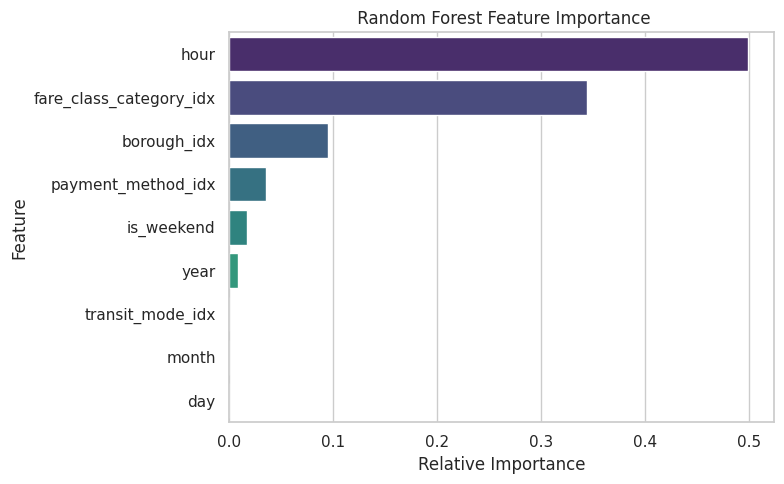

In [59]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Get feature importances from the trained RF model
importances = rf_model.featureImportances.toArray()
feature_names = [
    "hour", "day", "month", "year", "is_weekend",
    "transit_mode_idx", "borough_idx",
    "fare_class_category_idx", "payment_method_idx"
]

# Build DataFrame
feat_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values("Importance", ascending=False)

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(x="Importance", y="Feature", data=feat_df, palette="viridis")
plt.title(" Random Forest Feature Importance")
plt.xlabel("Relative Importance")
plt.tight_layout()
plt.show()


## 2.5: Predicted vs Actual Ridership Plot

### Predicted vs Actual Plot (Random Forest or GBT)

<ipython-input-58-5e15a0672088>:42: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


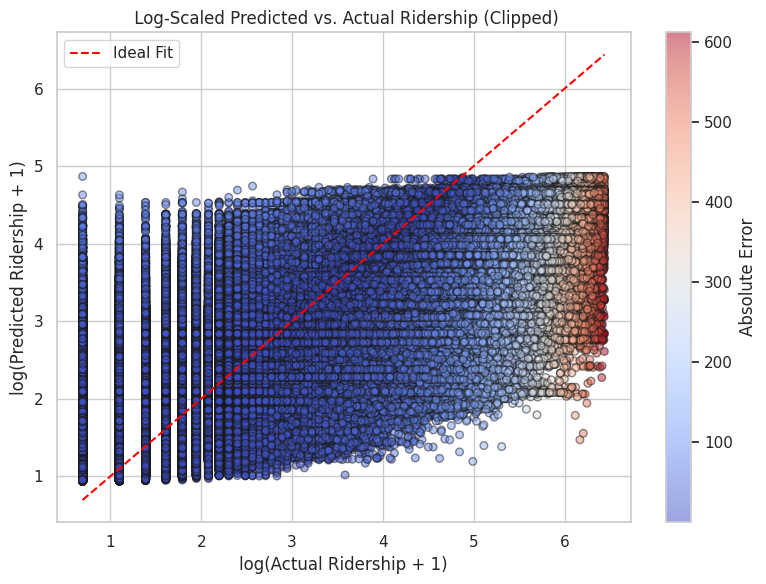

In [58]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Convert Spark DataFrame to Pandas
pdf_pred = predictions.select("prediction", "ridership").toPandas()

# Add log-transformed values and absolute error
pdf_pred["log_ridership"] = np.log1p(pdf_pred["ridership"])
pdf_pred["log_prediction"] = np.log1p(pdf_pred["prediction"])
pdf_pred["abs_error"] = np.abs(pdf_pred["ridership"] - pdf_pred["prediction"])

# Optional: filter out extreme outliers (99.5th percentile)
clip_threshold = pdf_pred["ridership"].quantile(0.995)
pdf_filtered = pdf_pred[pdf_pred["ridership"] <= clip_threshold]

# Plot with log axes and error coloring
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    np.log1p(pdf_filtered["ridership"]),
    np.log1p(pdf_filtered["prediction"]),
    c=pdf_filtered["abs_error"],
    cmap="coolwarm",
    alpha=0.5,
    edgecolor="k",
    s=30
)

# Add ideal line (log scale)
min_val = min(pdf_filtered[["ridership", "prediction"]].min())
max_val = max(pdf_filtered[["ridership", "prediction"]].max())
plt.plot([np.log1p(min_val), np.log1p(max_val)],
         [np.log1p(min_val), np.log1p(max_val)],
         color='red', linestyle='--', label="Ideal Fit")

plt.title(" Log-Scaled Predicted vs. Actual Ridership (Clipped)")
plt.xlabel("log(Actual Ridership + 1)")
plt.ylabel("log(Predicted Ridership + 1)")
plt.legend()
plt.colorbar(scatter, label="Absolute Error")
plt.tight_layout()
plt.show()


# **Section 3: Visualization of Ridership Trends and Anomalies**

Plot actual ridership, rolling average, and flagged anomalies to identify potential delays.

# 3.1: KMeans Clustering of Stations by Hourly Patterns

In [38]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import avg

# Step 1: Compute avg ridership per station per hour
df_kmeans = (
    df.groupBy("station_complex", "hour")
      .agg(avg("ridership").alias("avg_ridership"))
)

# Step 2: Pivot so each station gets 24 hourly values as features
df_pivot = df_kmeans.groupBy("station_complex").pivot("hour").avg("avg_ridership").fillna(0)

# Step 3: Assemble 24-hour feature vector
hour_cols = [str(h) for h in range(24)]
assembler = VectorAssembler(inputCols=hour_cols, outputCol="features")
df_cluster = assembler.transform(df_pivot)

# Step 4: Apply KMeans
kmeans = KMeans(featuresCol="features", predictionCol="cluster", k=4, seed=42)
model = kmeans.fit(df_cluster)
clustered = model.transform(df_cluster)

# View clustered stations
clustered.select("station_complex", "cluster").show(10, truncate=False)


+----------------------------------+-------+
|station_complex                   |cluster|
+----------------------------------+-------+
|Zerega Av (6)                     |0      |
|Broad Channel (A,S)               |0      |
|Grand Army Plaza (2,3)            |0      |
|Lorimer St (L)/Metropolitan Av (G)|1      |
|Halsey St (J)                     |0      |
|34 St-Hudson Yards (7)            |1      |
|Lexington Av-53 St (E,M)/51 St (6)|3      |
|DeKalb Av (B,Q,R)                 |1      |
|63 Dr-Rego Park (M,R)             |1      |
|Briarwood (E,F)                   |0      |
+----------------------------------+-------+
only showing top 10 rows



## 3.2: Outlier Detection Using Z-Scores

In [39]:
from pyspark.sql.functions import stddev, mean

# Step 1: Daily ridership per station
df_daily_station = (
    df.withColumn("date", F.to_date("ts"))
      .groupBy("station_complex", "date")
      .agg(F.sum("ridership").alias("daily_ridership"))
)

# Step 2: Compute station-level mean & std dev
stats = df_daily_station.groupBy("station_complex").agg(
    mean("daily_ridership").alias("mean_r"),
    stddev("daily_ridership").alias("std_r")
)

# Step 3: Join back and compute z-score
df_z = df_daily_station.join(stats, on="station_complex", how="inner")
df_z = df_z.withColumn("z_score", (F.col("daily_ridership") - F.col("mean_r")) / F.col("std_r"))

# Step 4: Flag outliers
outliers = df_z.filter((F.col("z_score") > 3) | (F.col("z_score") < -3))
outliers.select("station_complex", "date", "daily_ridership", "z_score").orderBy(F.desc("z_score")).show(10)


+--------------------+----------+---------------+------------------+
|     station_complex|      date|daily_ridership|           z_score|
+--------------------+----------+---------------+------------------+
|Coney Island-Stil...|2024-05-18|          10290|21.011399194939205|
|          215 St (1)|2022-10-22|           1556|16.800231783674892|
|   Beach 90 St (A,S)|2024-06-19|           1051| 16.65408696132837|
|           21 St (G)|2023-07-05|           1316|15.424912799838765|
|Mets-Willets Poin...|2023-09-03|          19943|14.481727226300825|
|Prospect Park (B,...|2024-04-28|           4631|14.300658785096251|
|    Norwood Av (J,Z)|2023-02-01|            999|13.149273162301649|
|          215 St (1)|2021-10-16|           1200|12.529274583400417|
|  Beach 105 St (A,S)|2024-06-19|            416|11.572763254415658|
|15 St-Prospect Pa...|2022-04-24|           2684|11.176910774652324|
+--------------------+----------+---------------+------------------+
only showing top 10 rows



## 3.3: Visualize Station Clusters (via PCA) & Highlight Outliers

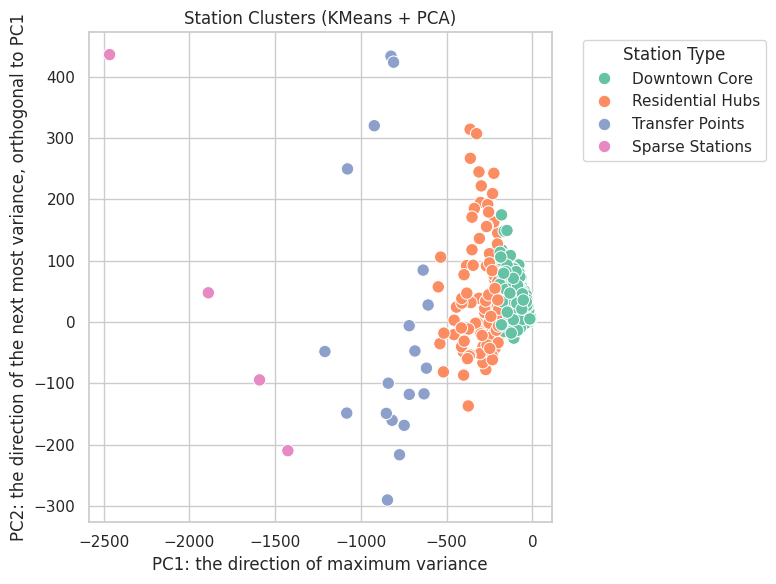

In [80]:
from pyspark.ml.feature import PCA
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Run PCA on 24-hour vectors
pca = PCA(k=2, inputCol="features", outputCol="pca_features")
pca_model = pca.fit(df_cluster)
pca_result = pca_model.transform(clustered)

# Convert to Pandas for plotting
pdf_pca = pca_result.select("station_complex", "cluster", "pca_features").toPandas()
pdf_pca["PC1"] = pdf_pca["pca_features"].apply(lambda x: float(x[0]))
pdf_pca["PC2"] = pdf_pca["pca_features"].apply(lambda x: float(x[1]))

# Optional: rename clusters for interpretability
cluster_labels = {
    0: "Downtown Core",
    1: "Residential Hubs",
    2: "Sparse Stations",
    3: "Transfer Points"
}
pdf_pca["cluster_label"] = pdf_pca["cluster"].map(cluster_labels)

# Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pdf_pca, x="PC1", y="PC2", hue="cluster_label", palette="Set2", s=80)
plt.title("Station Clusters (KMeans + PCA)")
plt.xlabel("PC1: the direction of maximum variance")
plt.ylabel("PC2: the direction of the next most variance, orthogonal to PC1")
plt.legend(title="Station Type", bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()


## 3.4: Average Hourly Ridership by Station Type

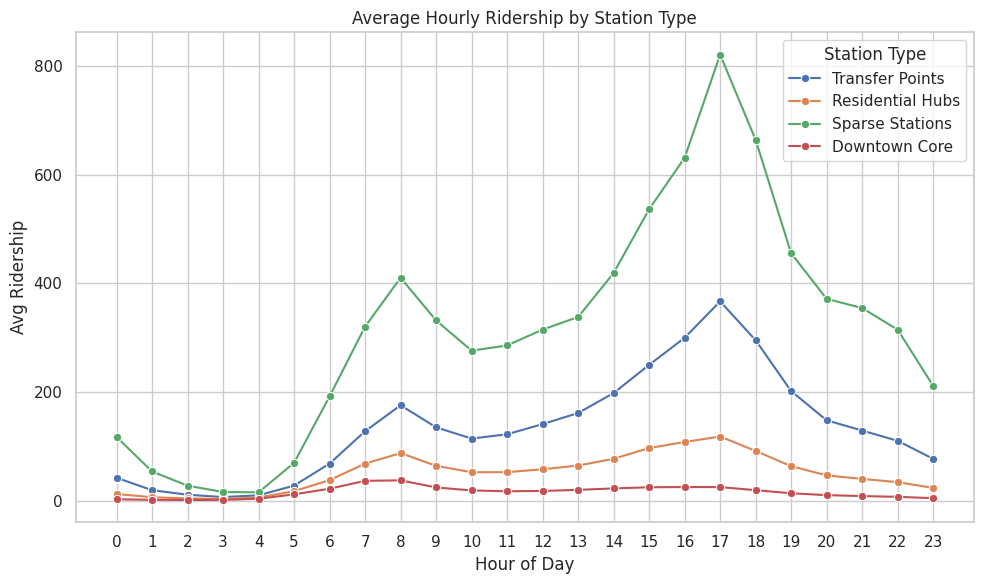

In [81]:
from pyspark.sql.functions import expr, avg
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Convert pivoted hours back to long format
hour_cols = [str(h) for h in range(24)]

melted = clustered.select("station_complex", "cluster", *hour_cols)

# Unpivot the 24 hour columns into key-value pairs
long_df = melted.selectExpr(
    "station_complex", "cluster",
    "stack(24, " + ", ".join([f"'{h}', `{h}`" for h in hour_cols]) + ") as (hour, ridership)"
).withColumn("hour", expr("cast(hour as int)"))

# Step 2: Group by cluster and hour to compute avg ridership
cluster_avg_df = long_df.groupBy("cluster", "hour").agg(avg("ridership").alias("avg_ridership"))

# Step 3: Convert to Pandas
pdf_cluster_avg = cluster_avg_df.toPandas()

# Step 4: Rename clusters
cluster_labels = {
    0: "Downtown Core",
    1: "Residential Hubs",
    2: "Sparse Stations",
    3: "Transfer Points"
}
pdf_cluster_avg["cluster"] = pdf_cluster_avg["cluster"].map(cluster_labels)

# Step 5: Plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=pdf_cluster_avg, x="hour", y="avg_ridership", hue="cluster", marker="o")
plt.title("Average Hourly Ridership by Station Type")
plt.xlabel("Hour of Day")
plt.ylabel("Avg Ridership")
plt.xticks(range(0, 24))
plt.grid(True)
plt.legend(title="Station Type")
plt.tight_layout()
plt.show()


## 3.5: Rolling Ridership Trends and Anomaly Detection

<ipython-input-67-65c5d071678f>:41: UserWarning: Glyph 9201 (\N{STOPWATCH}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9201 (\N{STOPWATCH}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


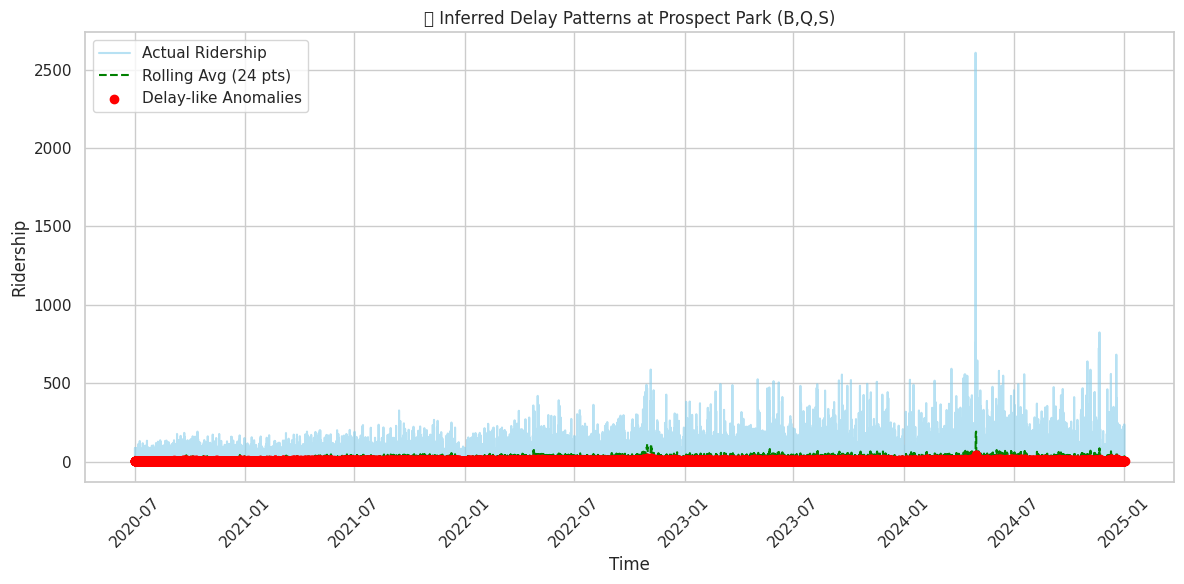

In [67]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from pyspark.sql.window import Window
from pyspark.sql.functions import col, avg, when

# 1. Rolling avg window (based on last 24 rows per station)
window_spec = Window.partitionBy("station_complex").orderBy("ts").rowsBetween(-24, 0)

df_anomaly = df.withColumn("roll_avg", avg("ridership").over(window_spec)) \
               .withColumn("anomaly_flag", when(col("ridership") < 0.3 * col("roll_avg"), 1).otherwise(0))

# 2. Pick a station (first one)
sample_station = df_anomaly.select("station_complex").distinct().limit(1).collect()[0][0]

# 3. Filter and prepare data — cast timestamp to string to avoid conversion issue
station_df = df_anomaly.filter(col("station_complex") == sample_station) \
                       .select(col("ts").cast("string").alias("ts_str"),
                               "ridership", "roll_avg", "anomaly_flag") \
                       .orderBy("ts_str")

# 4. Convert to Pandas and fix datetime parsing
pdf = station_df.toPandas()
pdf["ts"] = pd.to_datetime(pdf["ts_str"], errors="coerce")
pdf.drop(columns=["ts_str"], inplace=True)

# 5. Plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=pdf, x="ts", y="ridership", label="Actual Ridership", color="skyblue", alpha=0.6)
sns.lineplot(data=pdf, x="ts", y="roll_avg", label="Rolling Avg (24 pts)", color="green", linestyle="--")
plt.scatter(pdf[pdf["anomaly_flag"] == 1]["ts"],
            pdf[pdf["anomaly_flag"] == 1]["ridership"],
            color="red", label="Delay-like Anomalies", zorder=5)

plt.title(f"⏱️ Inferred Delay Patterns at {sample_station}")
plt.xlabel("Time")
plt.ylabel("Ridership")
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()
